# SDTW on Training with Unaligned Dataset
# Setting up Environment

```
$ python -m venv sdtw
$ source sdtw/bin/activate # for linux
$ ./sdtw/Scripts/activate # for windows
$ python.exe -m pip install --upgrade pip # upgrade pip
$ pip install -r requirements.txt
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.core.display as ipd
import pandas as pd
import os

import lib.helpers.data_utils as data_utils
import lib.training.trainer as trainer

import torch
import libfmp.b
import libfmp.c5

from lib.nn_losses.soft_dtw_cuda import SoftDTW
from lib.nn_models.nn_dchord import dchord_pipeline
# from lib.helpers.soft_align import soft_align


# Preparing Data for Training

In [2]:
nonchord = False
data_basedir = './res/data'

In [3]:
song_dict = {}

song_dict[0] = ['LetItB', 'r',
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav'),
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original_Chords_simplified.csv')]
song_dict[1] = ['HereCo', 'b',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07_Chords_simplified.csv')]
song_dict[2] = ['ObLaDi', 'c',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04_Chords_simplified.csv')]
song_dict[3] = ['PennyL', 'g',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09_Chords_simplified.csv')]
song_dict[4] = ['LetItBFull', 'r', 
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords_simplified.csv')]

In [4]:
def compute_X_dict(song_selected, version='STFT', details=True, nonchord=False):
    X_dict = {}
    Fs_X_dict = {}
    ann_dict = {}
    x_dur_dict = {}
    chord_labels = libfmp.c5.get_chord_labels(ext_minor='m', nonchord=nonchord)
    for s in song_selected:
        if details is True:
            print('Processing: ', song_dict[s][0])
        fn_wav = song_dict[s][2]
        fn_ann = song_dict[s][3]
#         N = 2048
#         H = 1024
        N = 4096
        H = 2048
        if version == 'STFT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')            # no log compression
        if version == 'CQT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, H=H, version='CQT')                  # no log compression
        if version == 'IIR':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=10, version='IIR')             # no log compression
            
        X_dict[s] = X
        Fs_X_dict[s] = Fs_X
        x_dur_dict[s] = x_dur
        N_X = X.shape[1]
        ann_dict[s] = libfmp.c5.convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=False)
    return X_dict, Fs_X_dict, ann_dict, x_dur_dict, chord_labels
    
song_selected = [0, 1, 2, 3, 4]
#song_selected = [0]
print('===== Computation of STFT-based chromagrams =====')
X_dict_STFT, Fs_X_dict_STFT, ann_dict_STFT, x_dur_dict, chord_labels = compute_X_dict(song_selected, version='STFT', nonchord=nonchord)

===== Computation of STFT-based chromagrams =====
Processing:  LetItB
Processing:  HereCo
Processing:  ObLaDi
Processing:  PennyL
Processing:  LetItBFull


## Create Dataset + Dataloader

In [5]:
train_set_indices = [1, 2, 4]
train_set_params = {'segment_length': 150, 'soft_length': 16}

train_set_strong = data_utils.create_dataset(data_dict=X_dict_STFT,
                            ann_dict=ann_dict_STFT, 
                            song_dict=song_dict, 
                            song_indices=train_set_indices, 
                            dataset_params=train_set_params, 
                            dataset_description='train_strong',
                            mode='strong',
                            pad='uniform')

train_set = data_utils.create_dataset(data_dict=X_dict_STFT, 
                           ann_dict=ann_dict_STFT, 
                           song_dict=song_dict, 
                           song_indices=train_set_indices, 
                           dataset_params=train_set_params, 
                           dataset_description='train',
                           mode='soft',
                           pad='last')

print('\n')

val_set_indices = [3]
val_set_params = {'segment_length': 150, 'soft_length': 16}

val_set = data_utils.create_dataset(data_dict=X_dict_STFT, 
                         ann_dict=ann_dict_STFT, 
                         song_dict=song_dict, 
                         song_indices=val_set_indices, 
                         dataset_params=val_set_params, 
                         dataset_description='val',
                         mode='soft',
                         pad='last')

- HereCo added to train_strong set. Segments: 13
- ObLaDi added to train_strong set. Segments: 13
- LetItBFull added to train_strong set. Segments: 17
Total segments created for train_strong dataset: 43
- HereCo added to train set. Segments: 13
- ObLaDi added to train set. Segments: 13
- LetItBFull added to train set. Segments: 17
Total segments created for train dataset: 43


- PennyL added to val set. Segments: 12
Total segments created for val dataset: 12


C:\Users\admin\AppData\Local\Temp\ipykernel_53312\1340157417.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4416.)
  libfmp.b.plot_chromagram(stft1.T, ax=[ax[0]], Fs=1, clim=[0, 1], xlabel='Frame index',


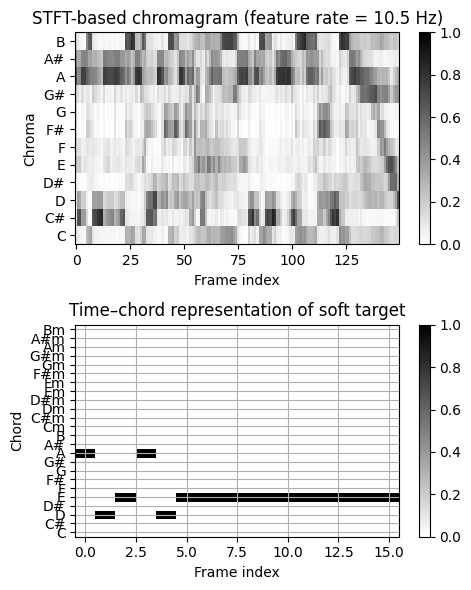

In [6]:
Fs_X = 10.5
# Visualizing Soft Target
for sample_seg, sample_target in train_set:
    stft1 = sample_seg
    chord1 = sample_target
    break

# Plot soft target sample
fig, ax = plt.subplots(2, 1, figsize=(5, 6))
libfmp.b.plot_chromagram(stft1.T, ax=[ax[0]], Fs=1, clim=[0, 1], xlabel='Frame index',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
libfmp.b.plot_matrix(chord1.T, ax=[ax[1]], Fs=1,
                        title='Time–chord representation of soft target',
                        ylabel='Chord', xlabel='Frame index')
ax[1].grid()
ax[1].set_yticks(np.arange( len(chord_labels) ))
ax[1].set_yticklabels(chord_labels)
plt.tight_layout()

In [7]:
train_loader_params = {'batch_size': 43, 'shuffle': True, 'num_workers': 0, 'collate_fn': None}
train_loader = torch.utils.data.DataLoader(train_set, **train_loader_params)
print(f'Training data loader contains {len(train_loader)} mini batches.')

train_loader_strong_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0, 'collate_fn': None}
train_loader_strong = torch.utils.data.DataLoader(train_set_strong, **train_loader_strong_params)

train_loader_soft_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0, 'collate_fn': None}
train_loader_soft = torch.utils.data.DataLoader(train_set, **train_loader_soft_params)

val_loader_params = {'batch_size': 12, 'shuffle': False, 'num_workers': 0, 'collate_fn': None}
val_loader = torch.utils.data.DataLoader(val_set, **val_loader_params)
print(f'Validation data loader contains {len(val_loader)} mini batches.')

Training data loader contains 1 mini batches.
Validation data loader contains 1 mini batches.


# Train Pipeline

# Initalize dChord Network

In [8]:
# Pipeline config

compression_params = {'gamma_init': 1.0,
                      'trainable': True}

feature_norm_params = {'num_features': 12,
                       'norm': '2', 
                       'threshold': 1e-4}

chord_template_params = {'shared_weights': True, 
                         'initialize_parameters': True, 
                         'normalize_weights': False}

softmax_params = {'tau': 1, 
                  'trainable': False}

In [9]:
model = dchord_pipeline(compression_params=compression_params, 
                        feature_norm_params=feature_norm_params, chord_template_params=chord_template_params,
                        softmax_params=softmax_params)

In [10]:
import torchinfo

torchinfo.summary(model, input_size=(1, 1, 150, 12), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
dchord_pipeline                          [1, 1, 150, 12]      [1, 1, 150, 24]      --                   Partial
├─log_compression: 1-1                   [1, 1, 150, 12]      [1, 1, 150, 12]      1                    True
├─feature_normalization: 1-2             [1, 1, 150, 12]      [1, 1, 150, 12]      --                   --
├─dchord_templates: 1-3                  [1, 1, 150, 12]      [1, 1, 150, 24]      --                   True
│    └─Conv2d: 2-1                       [1, 1, 150, 23]      [1, 2, 150, 12]      24                   True
├─softmax_temperature: 1-4               [1, 1, 150, 24]      [1, 1, 150, 24]      (1)                  False
Total params: 26
Trainable params: 25
Non-trainable params: 1
Total mult-adds (Units.MEGABYTES): 0.04
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.08

## Specify which parameters to optimize

In [11]:
print('Trainable parameters:\n')

trainable_parameters = []
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_parameters.append(name)
        print(f"'{name}'") 

Trainable parameters:

'log_compression.log_gamma'
'chord_template_params.filter.weight'


Optimization mode $\in \{0, 1, 2 \}$:  
- 0: optimize all trainable parameters 
- 1: optimize **all** trainable parameters **except** the ones specified in `frozen_parameters`
- 2: optimize **only** the parameters specified in `trained_parameters`

(`frozen_parameters` and `trained_parameters` must be lists of strings and a subset of the trainable parameters shown above)

For no optimization at all: set training epochs to zero.

In [12]:
optimization_mode = 0

if optimization_mode == 1:
    frozen_parameters = []           

if optimization_mode == 2:
    trained_parameters = []

In [13]:
if optimization_mode == 0:
    parameters_to_optimize = model.parameters()
    
elif optimization_mode == 1:
    parameters_to_optimize = []

    for name, param in model.named_parameters():
        if not name in frozen_parameters:
            parameters_to_optimize.append(param)
            
elif optimization_mode == 2:
    parameters_to_optimize = []

    for name, param in model.named_parameters():
        if name in trained_parameters:
            parameters_to_optimize.append(param)

### Set Optimizer, Training Parameters and Loss

In [14]:
optim_params = {'lr': 0.1, 'betas': (0.9, 0.999)}
optimizer = torch.optim.Adam(parameters_to_optimize, **optim_params)

In [15]:
training_params = {'device': 'cpu', 'max_epochs': 200, 'split_weak_batch': False}
# training_params = {'device': 'cuda:0', 'max_epochs': 25}

# weights for fighting class imbalance major / minor in training dataset
# weight = torch.cat((torch.ones(12), torch.ones(12)))           
weight = torch.cat((torch.ones(12), 19*torch.ones(12)))

crit = torch.nn.NLLLoss(weight=weight, reduction='mean').to(training_params['device'])  # Categorical CE without log

In [16]:
normalize = False

crit = SoftDTW(use_cuda=False, gamma=0.3, dist_func=None, normalize=normalize)

### Network Training - Weakly Aligned Dataset

Train the model. After each training epoch (one iteration over the train dataloader), evaluate performanceon the validation set. We use a variable `best_model` that contains the current best model (the model with the overall lowest validation loss). At the end of the training, the `best_model` ist used for evaluation.

In [17]:
model_pipeline = model.to(training_params['device'])
model_trainer = trainer.Trainer(model=model_pipeline,
                                crit=crit,
                                optimizer=optimizer,
                                train_dl=train_loader,
                                val_dl=val_loader,
                                training_param=training_params,
                                save_e_matrix_to=True,
                                save_e_matrix_params={'save_path': 'e_matrix', 'every_n_epochs': 10},
                                plot_loader=train_loader_soft,
                                plot_loader_strong=train_loader_strong)
best_model, train_losses, val_losses = model_trainer.fit()

y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 1/200, Train Loss: 128.2337, Val Loss: 124.7588
x_strong: torch.Size([1, 1, 150, 12]), y_strong: torch.Size([1, 1, 150, 24])
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 2/200, Train Loss: 124.9620, Val Loss: 122.6541
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 3/200, Train Loss: 122.9835, Val Loss: 121.6016
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 4/200, Train Loss: 121.9609, Val Loss: 120.9875
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 5/200, Train Loss: 121.2933, Val Loss: 120.4925
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 6/200, Train Loss: 120.6906, Val Loss: 119.9976
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 7/200, Train Loss: 120.0571, Val Loss: 119.4606
 .

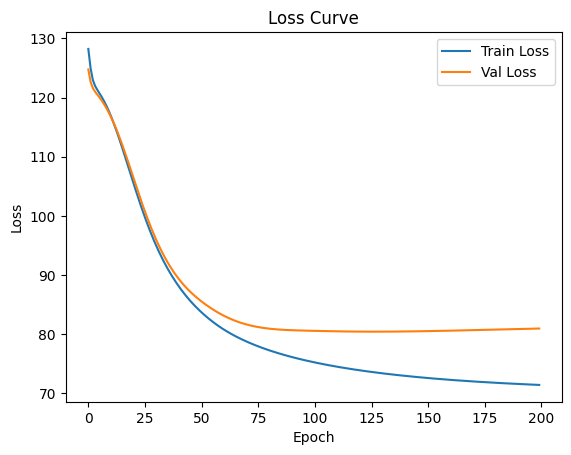

In [18]:
if len(train_losses) > 1:
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

# Investigate Model

In [19]:
import matplotlib
# Class for visualizing chord templates with zero-centered diverging colormap

# Example of making your own norm.  Also see matplotlib.colors.
# From Joe Kington: This one gives two different linear ramps:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))



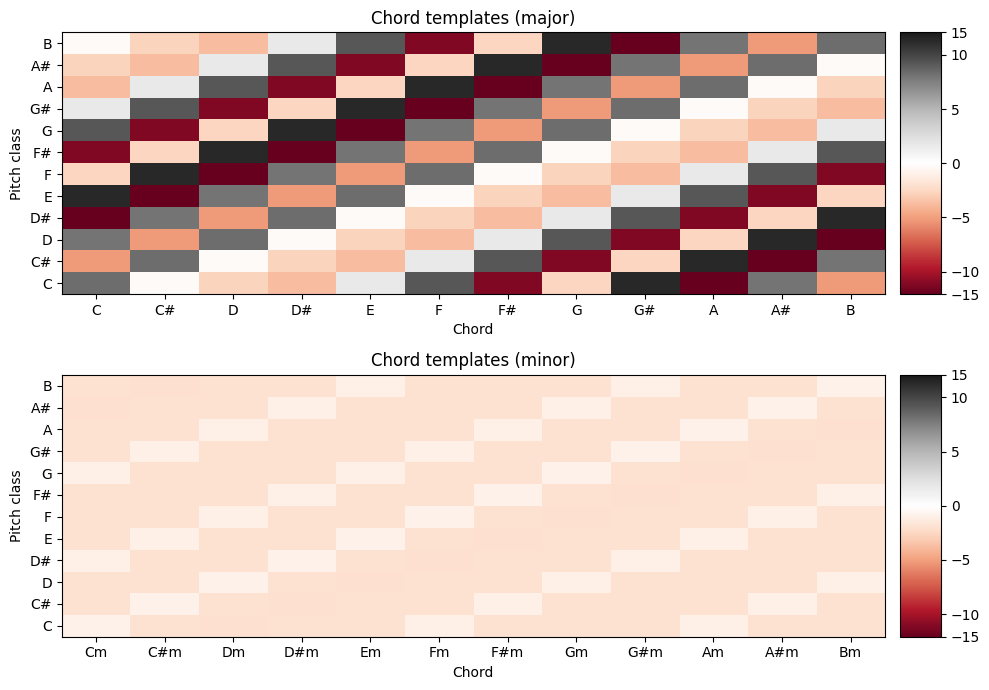

In [20]:
chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
ext_minor = 'm'
chord_labels_maj = chroma_labels
chord_labels_min = [s + ext_minor for s in chroma_labels]
chord_labels = chord_labels_maj + chord_labels_min

# read weights from layer
weights = model_pipeline.chord_template_params.filter.weight.to('cpu').detach()
weights = np.squeeze(weights)

templates_maj = np.zeros((12,12))
templates_min = np.zeros((12,12))

if weights.shape[0] == 2:
    for n in range(12):           # shared weights -> templates are only shifted versions of each other
        templates_maj[:, n] = np.roll(weights[0], n)
        templates_min[:, n] = np.roll(weights[1], n)
    
elif weights.shape[0] == 24:
    templates_maj = np.asarray(weights[:12, :]).T
    templates_min = np.asarray(weights[12:, :]).T
    

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 7))
    
# determine appropriate colormap for plots
if np.min([templates_maj, templates_min]) < 0:
    abs_max = np.abs([templates_maj, templates_min]).max()
    plot_parameters = {'cmap': 'RdGy', 'norm': MidpointNormalize(vmin=-abs_max, vmax=abs_max, midpoint=0, clip=False)}
else:
    plot_parameters = {'cmap': 'gray_r'}
    
# plot major chord templates
libfmp.b.plot_matrix(templates_maj, ax=[ax[0, 0], ax[0, 1]], 
                     title='Chord templates (major)',
                     ylabel='Pitch class', xlabel='Chord',
                     colorbar=True, **plot_parameters)
ax[0, 0].set_xticks(np.arange(12))
ax[0, 0].set_xticklabels(chord_labels_maj)
ax[0, 0].set_yticks(np.arange(12))
ax[0, 0].set_yticklabels(chroma_labels)

# plot minor chord templates
libfmp.b.plot_matrix(templates_min, ax=[ax[1, 0], ax[1, 1]], 
                     title='Chord templates (minor)',
                     ylabel='Pitch class', xlabel='Chord',
                     colorbar=True, **plot_parameters)
ax[1, 0].set_xticks(np.arange(12))
ax[1, 0].set_xticklabels(chord_labels_min)
ax[1, 0].set_yticks(np.arange(12))
ax[1, 0].set_yticklabels(chroma_labels)

plt.tight_layout()


# Testing on Let It Be Segment

In [21]:
# Chroma Features
fn_wav = os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav')
N = 4096
H = 2048
X_STFT, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')

# Annotations
fn_ann = os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original_Chords_simplified.csv')
ann, _ = libfmp.c4.read_structure_annotation(fn_ann)
color_ann = {'N': [1, 1, 1, 1], 'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 
             'Am': [1, 0, 0, 1], 'F': [0, 0, 1, 1]}


In [22]:
test_set_indices = [0]
# Soft Length parameters is irrelevant as we use full target for evaluation
test_set_params = {'segment_length': 1, 'soft_length': 8}

test_set = data_utils.create_dataset(data_dict=X_dict_STFT,
                            ann_dict=ann_dict_STFT, 
                            song_dict=song_dict, 
                            song_indices=test_set_indices, 
                            dataset_params=test_set_params, 
                            dataset_description='test',
                            mode='strong')

test_set_loader_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0, 'collate_fn': None}
test_set_loader = torch.utils.data.DataLoader(test_set, **test_set_loader_params)
print(f'Test data loader contains {len(test_set_loader)} mini batches.')


- LetItB added to test set. Segments: 138
Total segments created for test dataset: 138
Test data loader contains 138 mini batches.


In [23]:
chord_sim_torch_pipeline = np.zeros((0, 25 if nonchord else 24))
X_test_all = np.zeros((0, 12))
y_test_all = np.zeros((0, 25 if nonchord else 24))

# Set model to evaluation mode
model_pipeline.eval()

with torch.no_grad():
    for X_test, y_test in test_set_loader:
        X_test, y_test = X_test.to(training_params['device']), y_test.to(training_params['device'])

        # get model prediction
        y_pred_test = model_pipeline(X_test)
        
        # sequueze dimensions to 2
        y_pred_test = torch.squeeze(torch.squeeze(y_pred_test, 0), 0)  # Remove Batch and Channel dimensions

        y_test = torch.squeeze(torch.squeeze(y_test, 0), 0)


        chord_sim_torch_pipeline = np.append(chord_sim_torch_pipeline, torch.squeeze(torch.squeeze(y_pred_test, 1), 1).to('cpu').detach().numpy(), axis=0)
        X_test_all = np.vstack((X_test_all, X_test.cpu().numpy().squeeze()))
        y_test_all = np.vstack((y_test_all, y_test.cpu().numpy()))

(138, 12)
(138, 24)


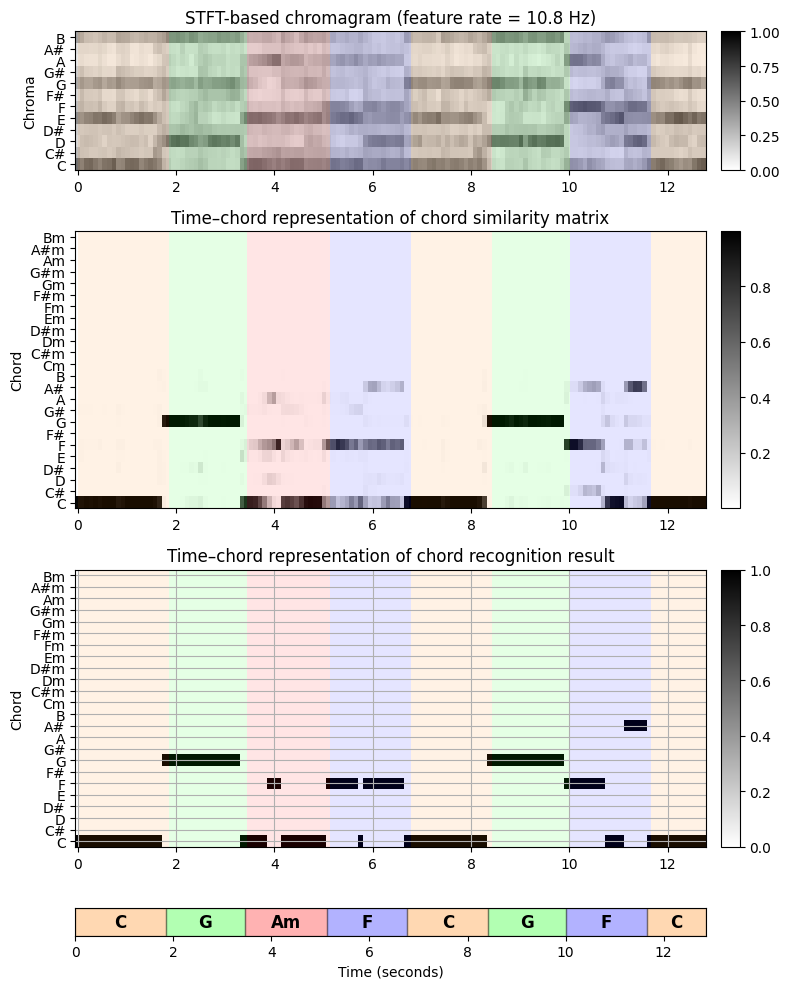

In [24]:
X_torch_pipeline = torch.unsqueeze(torch.unsqueeze(torch.tensor(X_dict_STFT[0].T, dtype=torch.float32), 1), 1)

chord_max_index_torch_pipeline = np.argmax(chord_sim_torch_pipeline, axis=-1)
chord_max_torch_pipeline = torch.zeros(chord_sim_torch_pipeline.shape, dtype=torch.int32)

for n in range(chord_sim_torch_pipeline.shape[0]):
    chord_max_torch_pipeline[n, chord_max_index_torch_pipeline[n]] = 1 
    
    
chord_labels = libfmp.c5.get_chord_labels(nonchord=nonchord)

print(X_test_all.shape)
print(y_test_all.shape)

# Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 3, 0.3]}, figsize=(8, 10))
libfmp.b.plot_chromagram(X_test_all.T, ax=[ax[0,0], ax[0,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
libfmp.b.plot_segments_overlay(ann, ax=ax[0,0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_matrix(chord_sim_torch_pipeline[:X_STFT.shape[1]].T, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord similarity matrix',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange( len(chord_labels) ))
ax[1, 0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(ann, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_matrix(chord_max_torch_pipeline[:X_STFT.shape[1]].T, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord recognition result',
                     ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange( len(chord_labels) ))
ax[2, 0].set_yticklabels(chord_labels)
ax[2, 0].grid()
libfmp.b.plot_segments_overlay(ann, ax=ax[2, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_segments(ann, ax=ax[3, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[3, 1].axis('off')
plt.tight_layout()

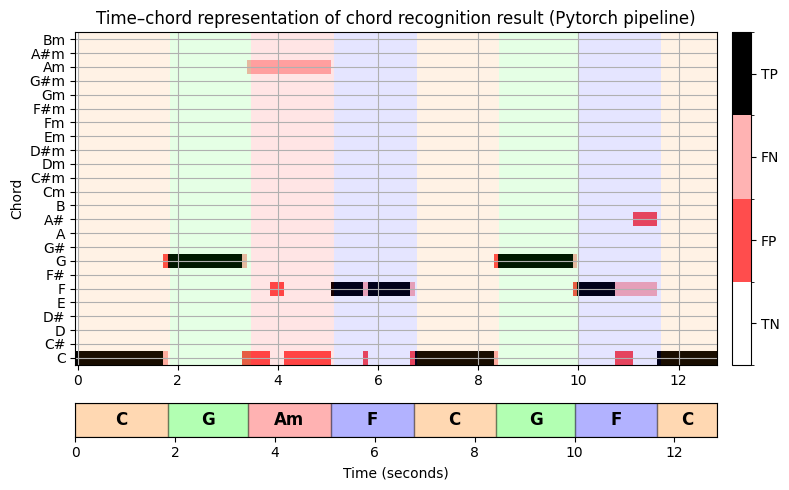

In [25]:
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 'height_ratios': [3, 0.3]}, figsize=(8, 5))

# Plot recognition result
libfmp.c5.plot_matrix_chord_eval(y_test_all.T, 
                                chord_max_torch_pipeline.numpy().T, 
                                ax=[ax[0, 0], ax[0, 1]], Fs=Fs_X_dict_STFT[test_set_indices[0]], 
                                title='Time–chord representation of chord recognition result (Pytorch pipeline)',
                                ylabel='Chord', xlabel='')
ax[0, 0].set_yticks(np.arange( len(chord_labels) ))
ax[0, 0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(ann, ax=ax[0, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_segments(ann, ax=ax[1, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[1, 1].axis('off')
plt.tight_layout()

In [26]:
# Compute Precision, Recall, F-measure

# Trained Pytorch chord recognition pipeline
P_torch_pipeline, R_torch_pipeline, F_torch_pipeline, _, _, _ = libfmp.c5.compute_eval_measures(y_test_all.T, chord_max_torch_pipeline.numpy().T)

print(f'\nPytorch - Trained Pipeline:')
print(f'{"Precision:" : <15}{P_torch_pipeline : .3f}')
print(f'{"Recall:" : <15}{R_torch_pipeline : .3f}')
print(f'{"F-measure:" : <15}{F_torch_pipeline : .3f}')


Pytorch - Trained Pipeline:
Precision:      0.761
Recall:         0.761
F-measure:      0.761


# Training with Unaligned Dataset - Uniform Padding
For this case we will loop the data in the batch and summing the loss over the batch. This is done to avoid padding the data in the batch, where it could undermine the intended test environment, where we use `sdtw` to calculate the loss of misaligned data.

In [27]:
train_set_indices = [1, 2, 4]
train_set_params = {'segment_length': 150, 'soft_length': 16}

train_set = data_utils.create_dataset(data_dict=X_dict_STFT, 
                           ann_dict=ann_dict_STFT, 
                           song_dict=song_dict, 
                           song_indices=train_set_indices, 
                           dataset_params=train_set_params, 
                           dataset_description='train',
                           mode='soft',
                           pad='uniform')

print('\n')

val_set_indices = [3]
val_set_params = {'segment_length': 150, 'soft_length': 16}

val_set = data_utils.create_dataset(data_dict=X_dict_STFT, 
                         ann_dict=ann_dict_STFT, 
                         song_dict=song_dict, 
                         song_indices=val_set_indices, 
                         dataset_params=val_set_params, 
                         dataset_description='val',
                         mode='soft',
                         pad='uniform')

- HereCo added to train set. Segments: 13
- ObLaDi added to train set. Segments: 13
- LetItBFull added to train set. Segments: 17
Total segments created for train dataset: 43


- PennyL added to val set. Segments: 12
Total segments created for val dataset: 12


In [28]:
train_loader_params = {'batch_size': 43, 'shuffle': True, 'num_workers': 0, 'collate_fn': None}
train_loader = torch.utils.data.DataLoader(train_set, **train_loader_params)
print(f'Training data loader contains {len(train_loader)} mini batches.')

val_loader_params = {'batch_size': 12, 'shuffle': False, 'num_workers': 0, 'collate_fn': None}
val_loader = torch.utils.data.DataLoader(val_set, **val_loader_params)
print(f'Validation data loader contains {len(val_loader)} mini batches.')

Training data loader contains 1 mini batches.
Validation data loader contains 1 mini batches.


In [29]:
no_pad_model = dchord_pipeline(compression_params=compression_params, 
                        feature_norm_params=feature_norm_params, chord_template_params=chord_template_params,
                        softmax_params=softmax_params)

In [30]:
optim_params = {'lr': 0.1, 'betas': (0.9, 0.999)}
optimizer = torch.optim.Adam(no_pad_model.parameters(), **optim_params)

In [31]:
no_pad_training= trainer.Trainer(model=no_pad_model,
                                crit=crit,
                                optimizer=optimizer,
                                train_dl=train_loader,
                                val_dl=val_loader,
                                training_param=training_params,
                                save_e_matrix_to=False,
                                save_e_matrix_params={'save_path': 'e_matrix_2', 'every_n_epochs': 1},
                                plot_loader=None,
                                plot_loader_strong=None)
best_model, train_losses, val_losses = no_pad_training.fit()

y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 1/200, Train Loss: 127.8120, Val Loss: 124.1297
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 2/200, Train Loss: 124.3913, Val Loss: 121.9786
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 3/200, Train Loss: 122.3136, Val Loss: 120.8428
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 4/200, Train Loss: 121.2036, Val Loss: 120.1198
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 5/200, Train Loss: 120.4428, Val Loss: 119.4929
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 6/200, Train Loss: 119.7395, Val Loss: 118.8470
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])
Epoch 7/200, Train Loss: 118.9989, Val Loss: 118.1441
 ....saved model
y_pred: torch.Size([12, 150, 24]), y: torch.Size([12, 16, 24])

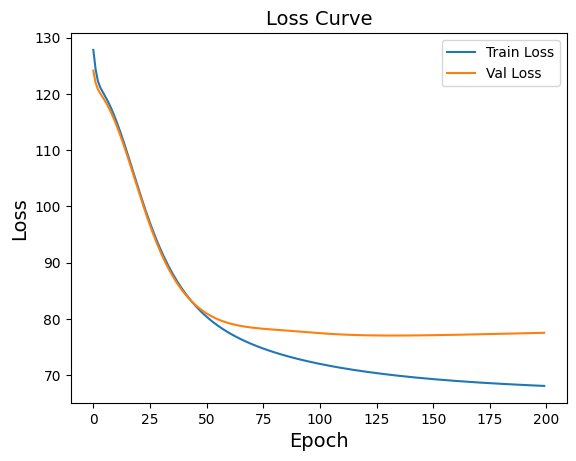

In [32]:
if len(train_losses) > 1:
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Loss Curve', fontsize=14)
    plt.legend()
    plt.show()

## Investigate Model - Uniform Padding

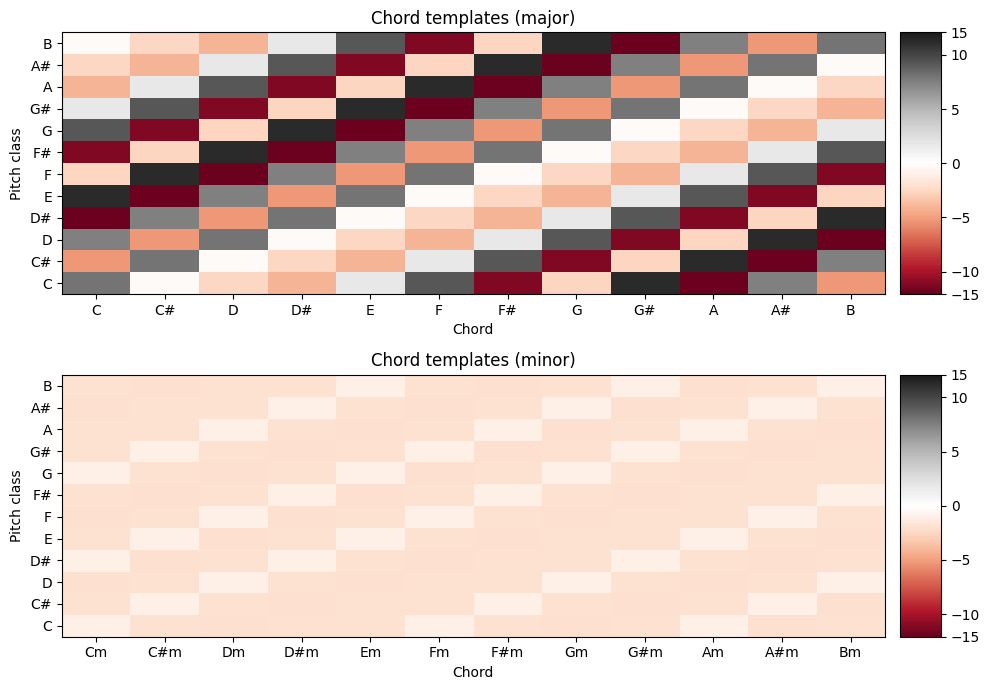

In [33]:
weights_no_pad = no_pad_model.chord_template_params.filter.weight.to('cpu').detach()
weights_no_pad = np.squeeze(weights_no_pad)

if weights.shape[0] == 2:
    for n in range(12):           # shared weights -> templates are only shifted versions of each other
        templates_maj[:, n] = np.roll(weights_no_pad[0], n)
        templates_min[:, n] = np.roll(weights_no_pad[1], n)
        
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 7))
# plot major chord templates
libfmp.b.plot_matrix(templates_maj, ax=[ax[0, 0], ax[0, 1]], 
                     title='Chord templates (major)',
                     ylabel='Pitch class', xlabel='Chord',
                     colorbar=True, **plot_parameters)
ax[0, 0].set_xticks(np.arange(12))
ax[0, 0].set_xticklabels(chord_labels_maj)
ax[0, 0].set_yticks(np.arange(12))
ax[0, 0].set_yticklabels(chroma_labels)

# plot minor chord templates
libfmp.b.plot_matrix(templates_min, ax=[ax[1, 0], ax[1, 1]], 
                     title='Chord templates (minor)',
                     ylabel='Pitch class', xlabel='Chord',
                     colorbar=True, **plot_parameters)
ax[1, 0].set_xticks(np.arange(12))
ax[1, 0].set_xticklabels(chord_labels_min)
ax[1, 0].set_yticks(np.arange(12))
ax[1, 0].set_yticklabels(chroma_labels)

plt.tight_layout()

In [34]:
chord_sim_torch_pipeline = np.zeros((0, 25 if nonchord else 24))
X_test_all = np.zeros((0, 12))
y_test_all = np.zeros((0, 25 if nonchord else 24))

# Set model to evaluation mode
no_pad_model.eval()

with torch.no_grad():
    for X_test, y_test in test_set_loader:
        X_test, y_test = X_test.to(training_params['device']), y_test.to(training_params['device'])

        # get model prediction
        y_pred_test = no_pad_model(X_test)
        
        # sequueze dimensions to 2
        y_pred_test = torch.squeeze(torch.squeeze(y_pred_test, 0), 0)  # Remove Batch and Channel dimensions

        y_test = torch.squeeze(torch.squeeze(y_test, 0), 0)

        chord_sim_torch_pipeline = np.append(chord_sim_torch_pipeline, torch.squeeze(torch.squeeze(y_pred_test, 1), 1).to('cpu').detach().numpy(), axis=0)
        X_test_all = np.vstack((X_test_all, X_test.cpu().numpy().squeeze()))
        y_test_all = np.vstack((y_test_all, y_test.cpu().numpy()))

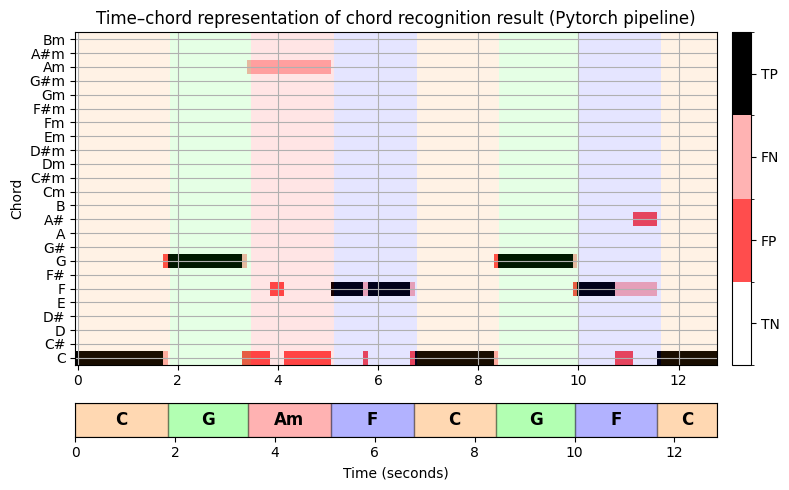

In [35]:
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 'height_ratios': [3, 0.3]}, figsize=(8, 5))

# Plot recognition result
libfmp.c5.plot_matrix_chord_eval(y_test_all.T, 
                                chord_max_torch_pipeline.numpy().T, 
                                ax=[ax[0, 0], ax[0, 1]], Fs=Fs_X_dict_STFT[test_set_indices[0]], 
                                title='Time–chord representation of chord recognition result (Pytorch pipeline)',
                                ylabel='Chord', xlabel='')
ax[0, 0].set_yticks(np.arange( len(chord_labels) ))
ax[0, 0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(ann, ax=ax[0, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_segments(ann, ax=ax[1, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[1, 1].axis('off')
plt.tight_layout()

In [36]:
# Compute Precision, Recall, F-measure

# Trained Pytorch chord recognition pipeline
P_torch_pipeline, R_torch_pipeline, F_torch_pipeline, _, _, _ = libfmp.c5.compute_eval_measures(y_test_all.T, chord_max_torch_pipeline.numpy().T)

print(f'\nPytorch - Trained Pipeline:')
print(f'{"Precision:" : <15}{P_torch_pipeline : .3f}')
print(f'{"Recall:" : <15}{R_torch_pipeline : .3f}')
print(f'{"F-measure:" : <15}{F_torch_pipeline : .3f}')


Pytorch - Trained Pipeline:
Precision:      0.761
Recall:         0.761
F-measure:      0.761


# Graphics - For Report
## Plot for Strong and Soft Targets

- HereCo added to train set. Segments: 13
- ObLaDi added to train set. Segments: 13
- LetItBFull added to train set. Segments: 17
Total segments created for train dataset: 43
- HereCo added to train set. Segments: 13
- ObLaDi added to train set. Segments: 13
- LetItBFull added to train set. Segments: 17
Total segments created for train dataset: 43


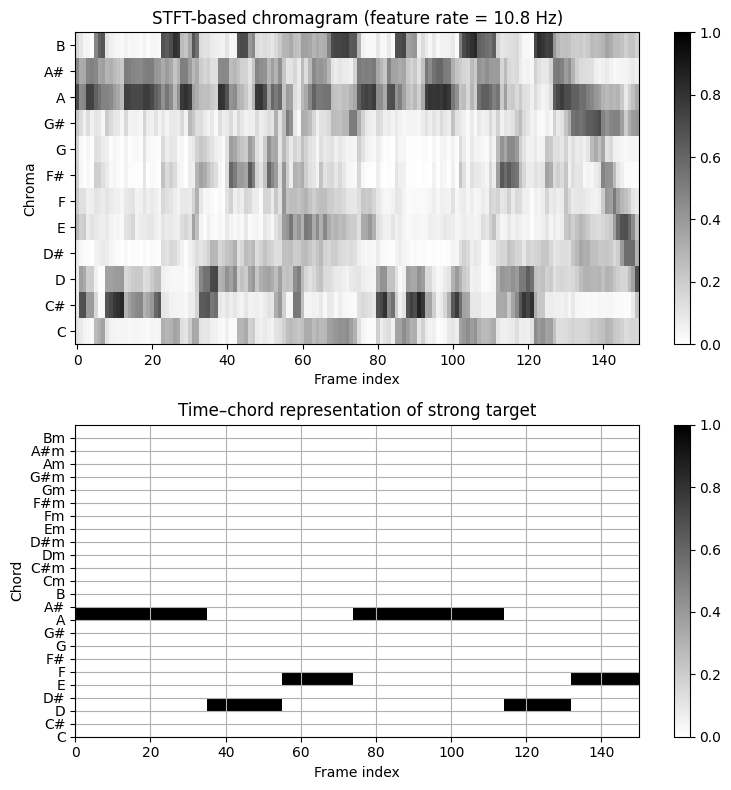

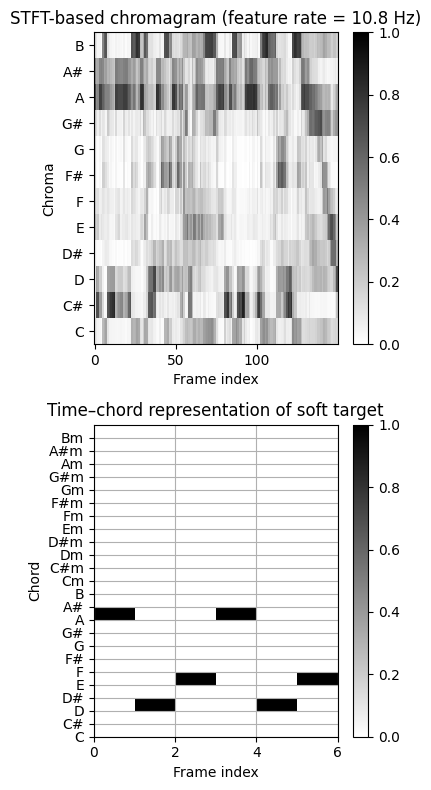

In [78]:
#Get strong dataset
strong_set = data_utils.create_dataset(data_dict=X_dict_STFT,
                            ann_dict=ann_dict_STFT, 
                            song_dict=song_dict, 
                            song_indices=train_set_indices, 
                            dataset_params=train_set_params, 
                            dataset_description='train',
                            mode='strong',
                            pad=None)
train_set_params = {'segment_length': 150, 'soft_length': 16}
strong_loader_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0, 'collate_fn': None}
soft_set = data_utils.create_dataset(data_dict=X_dict_STFT,
                            ann_dict=ann_dict_STFT, 
                            song_dict=song_dict, 
                            song_indices=train_set_indices, 
                            dataset_params=train_set_params, 
                            dataset_description='train',
                            mode='soft',
                            pad=None)
soft_loader_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0, 'collate_fn': None}
strong_loader = torch.utils.data.DataLoader(strong_set, **strong_loader_params)


# Strong target sample
for sample_seg, sample_target in strong_set:
    stft1 = sample_seg
    chord1 = sample_target
    break

# Plot strong target sample
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
libfmp.b.plot_chromagram(stft1.T, ax=[ax[0]], Fs=1, clim=[0, 1], xlabel='Frame index',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
libfmp.b.plot_matrix(chord1.T, ax=[ax[1]], Fs=1,
                        title='Time–chord representation of strong target',
                        ylabel='Chord', xlabel='Frame index', extent=[0, 150, 0, 24])
ax[1].grid()
ax[1].set_yticks(np.arange( len(chord_labels) ))
ax[1].set_yticklabels(chord_labels)
plt.tight_layout()




# Soft Target Sample
for sample_seg, sample_target in soft_set:
    stft1 = sample_seg
    chord1 = sample_target
    break

# Plot soft target sample
fig, ax = plt.subplots(2, 1, figsize=(4, 8))
libfmp.b.plot_chromagram(stft1.T, ax=[ax[0]], Fs=1, clim=[0, 1], xlabel='Frame index',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
libfmp.b.plot_matrix(chord1.T, ax=[ax[1]], Fs=1,
                        title='Time–chord representation of soft target',
                        ylabel='Chord', xlabel='Frame index', extent=[0, chord1.shape[1], 0, 24])
ax[1].grid()
ax[1].set_yticks(np.arange( len(chord_labels) ))
ax[1].set_yticklabels(chord_labels)
plt.tight_layout()

### Chord class distribution

In [39]:
strong_set_loader = torch.utils.data.DataLoader(strong_set, batch_size=1, shuffle=False)
num_maj_frames = 0
num_min_frames = 0
num_total_frames = 0

for _, y in strong_set_loader:
    num_maj_frames += y[:, :, :, :12].sum().item()
    num_min_frames += y[:, :, :, 12:].sum().item()
    num_total_frames += y.shape[2]

print(y.shape)
print(num_maj_frames, num_min_frames, num_total_frames)
    
print(f'{"Major chord percentage in training set:" : <40}{100 * num_maj_frames / num_total_frames : .2f}')
print(f'{"Minor chord percentage in training set:" : <40}{100 * num_min_frames / num_total_frames : .2f}')
print(f'{"No-chord percentage in training set:" : <40}{100 * (1 - (num_maj_frames + num_min_frames) / num_total_frames) : .2f}')

torch.Size([1, 1, 150, 24])
5843.0 607.0 6450
Major chord percentage in training set:  90.59
Minor chord percentage in training set:  9.41
No-chord percentage in training set:     0.00


In [40]:
soft_set_loader = torch.utils.data.DataLoader(soft_set, batch_size=1, shuffle=False)
num_maj_frames = 0
num_min_frames = 0
num_total_frames = 0

for _, y in soft_set_loader:
    num_maj_frames += y[:, :, :, :12].sum().item()
    num_min_frames += y[:, :, :, 12:].sum().item()
    num_total_frames += y.shape[2]

print(y.shape)
print(num_maj_frames, num_min_frames, num_total_frames)
    
print(f'{"Major chord percentage in training set:" : <40}{100 * num_maj_frames / num_total_frames : .2f}')
print(f'{"Minor chord percentage in training set:" : <40}{100 * num_min_frames / num_total_frames : .2f}')
print(f'{"No-chord percentage in training set:" : <40}{100 * (1 - (num_maj_frames + num_min_frames) / num_total_frames) : .2f}')

torch.Size([1, 1, 16, 24])
613.0 75.0 688
Major chord percentage in training set:  89.10
Minor chord percentage in training set:  10.90
No-chord percentage in training set:     0.00


In [41]:
soft16_set = data_utils.create_dataset(data_dict=X_dict_STFT,
                            ann_dict=ann_dict_STFT, 
                            song_dict=song_dict, 
                            song_indices=train_set_indices, 
                            dataset_params=train_set_params, 
                            dataset_description='train',
                            mode='soft',
                            pad='uniform')
soft16_set_loader = torch.utils.data.DataLoader(soft16_set, batch_size=50, shuffle=False)
num_maj_frames = 0
num_min_frames = 0
num_no_chord_frames = 0
num_total_frames = 0

for _, y in soft16_set_loader:
    num_maj_frames += y[:, :, :, :12].sum().item()
    num_min_frames += y[:, :, :, 12:].sum().item()
    num_total_frames += y.shape[2]*y.shape[0]

print(y.shape)
print(num_maj_frames, num_min_frames, num_total_frames)
    
print(f'{"Major chord percentage in training set:" : <40}{100 * num_maj_frames / num_total_frames : .2f}')
print(f'{"Minor chord percentage in training set:" : <40}{100 * num_min_frames / num_total_frames : .2f}')
print(f'{"No-chord percentage in training set:" : <40}{100 * (1 - (num_maj_frames + num_min_frames) / num_total_frames) : .2f}')

- HereCo added to train set. Segments: 13
- ObLaDi added to train set. Segments: 13
- LetItBFull added to train set. Segments: 17
Total segments created for train dataset: 43
torch.Size([43, 1, 16, 24])
613.0 75.0 688
Major chord percentage in training set:  89.10
Minor chord percentage in training set:  10.90
No-chord percentage in training set:     0.00


In [42]:
soft75_set_param = {
    'segment_length': 159,
    'soft_length': 75
}
soft75_set = data_utils.create_dataset(data_dict=X_dict_STFT,
                            ann_dict=ann_dict_STFT, 
                            song_dict=song_dict, 
                            song_indices=train_set_indices, 
                            dataset_params=soft75_set_param, 
                            dataset_description='train',
                            mode='soft',
                            pad='uniform')
soft75_set_loader = torch.utils.data.DataLoader(soft75_set, batch_size=50, shuffle=False)

num_maj_frames = 0
num_min_frames = 0
num_no_chord_frames = 0
num_total_frames = 0

for _, y in soft75_set_loader:
    num_maj_frames += y[:, :, :, :12].sum().item()
    num_min_frames += y[:, :, :, 12:].sum().item()
    num_total_frames += y.shape[2]*y.shape[0]

print(y.shape)
print(num_maj_frames, num_min_frames, num_total_frames)

print(f'{"Major chord percentage in training set:" : <40}{100 * num_maj_frames / num_total_frames : .2f}')
print(f'{"Minor chord percentage in training set:" : <40}{100 * num_min_frames / num_total_frames : .2f}')
print(f'{"No-chord percentage in training set:" : <40}{100 * (1 - (num_maj_frames + num_min_frames) / num_total_frames) : .2f}')

- HereCo added to train set. Segments: 12
- ObLaDi added to train set. Segments: 12
- LetItBFull added to train set. Segments: 16
Total segments created for train dataset: 40
torch.Size([40, 1, 75, 24])
2656.0 344.0 3000
Major chord percentage in training set:  88.53
Minor chord percentage in training set:  11.47
No-chord percentage in training set:     0.00


## Caveat
The current network attempts to train how to predict a single frame with temporal context. What really happens is that it take out a frame, with +-25 for context; then predict which chord corresponds to that frame.

For misalignment this is not neccessary, as we would simple load the whole sequence with multiple frames, then align it implicitly and output the whole sequence.

`TODO List`

- ~~refactor by remove temporal smoothness process.~~
- ~~fix dimension so that predict and target fits the loss~~
- ~~fix soft_align so that it produce one-hot-encoding~~
- ~~allow stacking batch (error occured when stacking different dim)~~
- ~~try plot path and final weight~~
- get results from strongly aligned for comparison
- refactor functions (so that it works both 'ctc' and 'sdtw' on-demand)

`IDEAL`: parse L frames `(B,1,L,12)` and predict corresponding sequence `(B,1,L,24)`

Then for testing, we can effectively parse the input sequence, predict then plot it.